<a href="https://colab.research.google.com/github/YeongRoYun/BearTeam/blob/dev/data/COCO_Converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=614

위의 형식을 COCO Format으로 재구성합니다.

```
{
"info": info, "images": [image], "annotations": [annotation], "licenses": [license],
}

info{
"year": int, "version": str, "description": str, "contributor": str, "url": str, "date_created": datetime,
}

image{
"id": int, "width": int, "height": int, "file_name": str, "license": int, "flickr_url": str, "coco_url": str, "date_captured": datetime,
}

license{
"id": int, "name": str, "url": str,
}
```

```
annotation{
"id": int, "image_id": int, "category_id": int, "segmentation": RLE or [polygon], "area": float, "bbox": [x,y,width,height], "iscrowd": 0 or 1,
}

categories[{
"id": int, "name": str, "supercategory": str,
}]
```

- AI-HUB 데이터의 BBOX를 확인했을 때, x_min,y_min, w, h의 형식을 동일하게 유지하였다.

In [92]:
import os
import re
import json
import random
import subprocess
import numpy as np
from PIL import Image as PILImage
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from PIL.Image import Resampling
from enum import Enum, unique, auto


from typing import List, Dict, Tuple, Optional
from pydantic import BaseModel


class ConvertConfig(BaseModel):
    src: Path
    dest: Path
    width: int
    height: int
    numSample: int

class Info(BaseModel):
    year: int
    version: str
    description: str
    contributor: str
    url: str
    date_created: str
        
class Image(BaseModel):
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
        

class License(BaseModel):
    id: int
    name: str
    url: str

class Annotation(BaseModel):
    id: int
    image_id: int
    category_id: int
    bbox: Tuple[float, float, float, float] # x_min, y_min, w, h

class Category(BaseModel):
    id: int
    name: str
    supercategory: str
        
class COCOFormat(BaseModel):
    info: Info
    categories: List[Category]
    images: List[Image]
    annotations: List[Annotation]
    licenses: List[License]

        
@unique
class CategoryEnum(Enum):
    BICYCLE = auto()
    MOTORCYCLE = auto()
    KICKBOARD = auto()

    def __str__(self):
        if self == CategoryEnum.BICYCLE:
            return 'bicycle'
        elif self == CategoryEnum.MOTORCYCLE:
            return 'motorcycle'
        elif self == CategoryEnum.KICKBOARD:
            return 'kickboard'
        else:
            return 'Not defined'

    def __int__(self):
        if self == CategoryEnum.BICYCLE:
            return 0
        elif self == CategoryEnum.MOTORCYCLE:
            return 1
        elif self == CategoryEnum.KICKBOARD:
            return 2
        else:
            return -1
        
class Converter:
    def __init__(self, config:ConvertConfig, train=True):
        self.config = config
        self.train = train
        self.trainPath = self.config.dest / 'Training'
        self.validPath = self.config.dest / 'Validation'
        
        self.logPath = self.currentDirectory / 'converter.log'
        
        self.imgPath = self.currentDirectory / 'images'
        self.annoPath = self.currentDirectory / 'annotations'
        
        self.annoDest = self.annoPath / 'main.json'
        
    @property
    def currentDirectory(self):
        return self.trainPath if self.train else self.validPath
        
    def run(self):
        isMade = self._make_dirs()
        
        with open(self.logPath, 'w') as fd:
            fd.write(f"Start converting from {self.config.src}\n")
            fd.write(f"Mode: {'Train' if self.train else 'Validation'}\n")
            fd.write(f"Saved at {self.currentDirectory}\n")
            
            if not isMade:
                fd.write(f"Can't make {self.currentDirectory}...\n")
                return None
            
            if not self._is_continue(fd):
                return None
            
            fd.write(f"Running...\n")
            info = self._get_info(fd)
            categories = self._get_categories(fd)
            licenses = self._get_licenses(fd)
            images, annotations = self._get_imgs_and_annos(fd)
            
            # Build
            fd.write("Build main.json...")
            main = COCOFormat(info=info, categories=categories, images=images, \
                              annotations=annotations, licenses = licenses)
            
            with open(self.annoDest, 'w') as destFD:
                destFD.write(main.json())
            fd.write("Done!!")
        
            fd.write("Finish convert!!!\n")
            fd.write("Have a nice day!!!\n")
        return None
            
                
    def _is_continue(self, fd)->bool:
        answer = ''
        while answer not in {'yes', 'no'}:
            answer = input("Original files are changed. Continue?(yes/no) ")
        if answer == 'yes':
            return True
        elif answer == 'no':
            fd.write(f"Thank you... Have a nice day!")
            return False
    
    def _make_dirs(self)->bool:
        if self.currentDirectory.exists():
            ret = subprocess.run(['rm', '-rf', self.currentDirectory])
            if ret.returncode == 0:
                os.makedirs(self.currentDirectory, exist_ok=True)
                os.makedirs(self.imgPath, exist_ok=True)
                os.makedirs(self.annoPath, exist_ok=True)
                return True
        return False
    
    def _get_info(self, fd)->Info:
        fd.write(f"Make info...")
        info = Info(year = 2022, version = 1, description="AI-HUB Dataset", contributor="에프원소프트", \
                   url=r'https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=614', \
                   date_created=str(datetime.now()).split()[0].replace('-', '/'))
        fd.write(f"Done!!\n")
        return info
    
    def _get_categories(self, fd)->List[Category]:
        fd.write(f"Make categories...")
        categories = [Category(id=int(category), name=str(category), supercategory=str(category)) \
                    for category in CategoryEnum]
        fd.write(f"Done!!\n")
        return categories
    
    def _get_licenses(self, fd)->List[License]:
        fd.write(f"Make licenses...")
        licenses = [License(id=0, name="AI-HUB License", url="https://www.aihub.or.kr/")]
        fd.write(f"Done!!\n")
        return licenses
    
    def _get_imgs_and_annos(self, fd)->Tuple[List[Image], List[Annotation]]:
        """
        numSample을 사용해서 갯수 선택!
        """
        fd.write(f"Make images and annotations...\n")

        fd.write(f"Get rawPaths to {self.annoPath}(format: json)...")
        annoList = subprocess.run(['find', self.config.src, '-name', '*.json'], \
                                 capture_output=True).stdout.decode('utf-8').split('\n')
        fd.write(f"Done!\n")
        
        fd.write(f"Select {self.config.numSample}...")
        random.shuffle(annoList)
        fd.write(f"Done!\n")
        
        fd.write(f"Copy Images and Annotations...")
        for rawAnnoPath in annoList[:self.config.numSample]:
            rawImgPath = rawAnnoPath.split('/')
            rawImgPath[1] = '원천데이터'
            rawImgPath = '/'.join(rawImgPath)
            rawImgPath = re.sub(r'json', r'jpg', rawImgPath)
            
            ret = subprocess.run(['cp', rawImgPath, self.imgPath])
            if ret.returncode == 0:
                # Image 복사가 성공!
                subprocess.run(['cp', rawAnnoPath, self.annoPath])
        fd.write(f"Done!\n")
            
            
        fd.write(f"Convert annotations and images...\n")

        images: List[Image] = []
        annotations: List[Annotation] = []
        
        total = 0
        checkFormat = lambda file: True if re.match(r'.*\.json', str(annoFile)) and not re.match(r'.*/main.json', str(annoFile)) else False
        
        for cnt, annoFile in enumerate(self.annoPath.iterdir()):
            # cnt를 img와 anno의 공통 id로 사용한당
            if not checkFormat(annoFile):
                continue
                
            total += 1

            with open(annoFile, 'r') as annoFD:
                anno = json.load(annoFD)
                name = re.search(r'(.*)\.json', annoFile.name)[1]
                
                if not self._process_img(name):
                    fd.write(f"INVALID: {name}\n")
                    continue
                
                infos = self._process_anno(anno)
                if not infos:
                    fd.write(f"INVALID: {name}\n")
                    continue
                
                # Create Image and Annotation
                image = Image(id=cnt, width=self.config.width, height=self.config.height, \
                              file_name=name + '.jpg', license=0, \
                              date_captured=anno['info'].get('date', str(datetime.now())))
                images.append(image)
                
                for category, bbox in infos:
                    annotation = Annotation(id=cnt, image_id=image.id, category_id=category, bbox=bbox)
                    annotations.append(annotation)
            
            if (cnt + 1) % 10000 == 0:
                fd.write(f"{cnt + 1} Processed...\n")
        
        fd.write(f"Total: {total} processed...\n")
        
        # Clean
        fd.write(f"Clean files...")
        for annoFile in self.annoPath.iterdir():
            if annoFile != self.annoDest:
                subprocess.run(['rm', annoFile])
            
        fd.write(f"Done!!\n")
        return images, annotations
    
    def _process_img(self, name)->bool:
        """
        Resize
        """
        url = self.imgPath / (name + '.jpg')
        if url.exists():
            img = PILImage.open(url)
            img = img.resize((self.config.width, self.config.height), Resampling.BICUBIC)
            img.save(url)
            return True
        else:
            return False
    
    def _process_anno(self, anno) -> Optional[List[Tuple[int, Tuple[float, float, float, float]]]]:
        """
        Return: list(category_id, bbox_info)
        """
        rawWidth = anno['description']['imageWidth']
        rawHeight = anno['description']['imageHeight']
        
        PMs = [
            CategoryEnum.MOTORCYCLE,
            CategoryEnum.BICYCLE,
            CategoryEnum.KICKBOARD,
            CategoryEnum.KICKBOARD,
            CategoryEnum.MOTORCYCLE,
            CategoryEnum.BICYCLE,
            CategoryEnum.KICKBOARD,
            CategoryEnum.MOTORCYCLE,
            CategoryEnum.BICYCLE,
            CategoryEnum.KICKBOARD,
            CategoryEnum.MOTORCYCLE,
            CategoryEnum.BICYCLE,
            CategoryEnum.KICKBOARD,
            CategoryEnum.MOTORCYCLE,
            CategoryEnum.BICYCLE,
            CategoryEnum.KICKBOARD,
            CategoryEnum.MOTORCYCLE,
            CategoryEnum.BICYCLE,
            CategoryEnum.MOTORCYCLE,
            CategoryEnum.BICYCLE,
            CategoryEnum.KICKBOARD,
        ]
            
        
        # Resize bbox
        try:
            ret = []
            for obj in anno['annotations']['PM']:
                category = int(PMs[int(obj['PM_code']) - 1]) # PMs가 1-21인 정상적인 상황이라면 오류 X!!
                bbox = np.array(obj['points'], dtype=np.float32)
                bbox[0] = bbox[0] / float(rawWidth) * float(self.config.width)
                bbox[1] = bbox[1] / float(rawHeight) * float(self.config.height)
                bbox[2] = bbox[2] / float(rawWidth) * float(self.config.width)
                bbox[3] = bbox[3] / float(rawHeight) * float(self.config.height)
                
                ret.append((category, bbox.tolist()))
            return ret
                
        except KeyError:
            # 하나거나, 없거나
            print(anno['annotations']['PM'])
            if 'points' not in anno['annotations']['PM'].keys():
                return None
            else:
                obj = anno['annotations']['PM']
                
                category = int(PMs[int(obj['PM_code']) - 1]) # code는 1 - 21로 되어 있다.
                
                bbox = np.array(obj['points'], dtype=np.float32)
                bbox[0] = bbox[0] / float(rawWidth) * float(self.config.width)
                bbox[1] = bbox[1] / float(rawHeight) * float(self.config.height)
                bbox[2] = bbox[2] / float(rawWidth) * float(self.config.width)
                bbox[3] = bbox[3] / float(rawHeight) * float(self.config.height)
                
                return [(category, bbox.tolist())]



In [100]:
def testLogic():
    config = ConvertConfig(src='Sample', dest='Target', width=1920, height=1200, numSample=10)
    converter = Converter(config)
    converter.run()

testLogic()

Original files are changed. Continue?(yes/no) yes


{
    "info": {
        "year": 2022,
        "version": "1",
        "description": "AI-HUB Dataset",
        "contributor": "\uc5d0\ud504\uc6d0\uc18c\ud504\ud2b8",
        "url": "https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=614",
        "date_created": "2022/08/20"
    },
    "categories": [
        {
            "id": 0,
            "name": "bicycle",
            "supercategory": "bicycle"
        },
        {
            "id": 1,
            "name": "motorcycle",
            "supercategory": "motorcycle"
        },
        {
            "id": 2,
            "name": "kickboard",
            "supercategory": "kickboard"
        }
    ],
    "images": [
        {
            "id": 0,
            "width": 1920,
            "height": 1200,
            "file_name": "C000313_006_0100_C_D_F_0.jpg",
            "license": 0,
            "date_captured": "2022-08-20 12:32:49.050488"
        },
        {
            "id": 1,
           

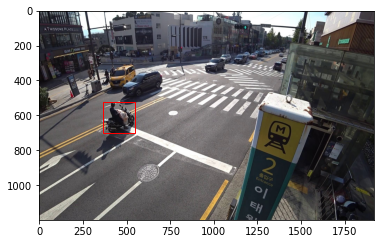

In [102]:
# Check
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def testBBOX():
    with open('Target/Training/annotations/main.json') as fd:
        anno = json.load(fd)
        print(json.dumps(anno, indent=4))

        img = PILImage.open(Path('Target/Training/images') / anno['images'][0]['file_name'])
        plt.imshow(img)
        ax = plt.gca()

        bbox =  anno['annotations'][0]['bbox']
        rect = Rectangle(bbox[:2], bbox[2], bbox[3], edgecolor='red', fill=False)
        ax.add_patch(rect)

testBBOX()